# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1] Read Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import random
import gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

C:\Users\chauh\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con = sql.connect('D:/Work/database.sqlite')

In [3]:
filtered_data = pd.read_sql_query("""select * from Reviews where Score != 3""", con)
filtered_data.shape

(525814, 10)

In [4]:
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'

In [5]:
actual_score = filtered_data['Score']
posneg = actual_score.map(partition)
filtered_data['Score'] = posneg

sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending= True, inplace= False, kind= 'quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

# [2] Data pre-processing

In [6]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

i=0
for sent in final['Text'].values:
    if len(re.findall('<.*?',sent)):
        print(i)
        print(sent)
        break
    i += 1    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{'it', 'after', "hasn't", 'she', 'when', "wouldn't", "don't", 'wouldn', 'while', 'to', 'under', 'doesn', 'hasn', 'against', "haven't", 'just', 'between', 'your', "should've", 'didn', 'nor', "she's", "didn't", "couldn't", 'over', 'why', 'so', 'hadn', 'be', 't', 'most', 'into', 'at', 'him', 'o', 'theirs', 'shan', 'you', 'been', 'myself', 'is', 'do', 'who', 'that', "that'll", 'aren', "needn't", 'their', 'will', 'll', 'up', 'on', 'this', 'were', 'how', 'off', 'no', 'itself', 'where', 're', 'm', 'don', 'which', 'other', 'because', 'some', 'down', 'herself', 'only', 'ours', "hadn't", 'his', 'yours', 'the', "you'll", 'any', 'same', "aren't", 'both', "shouldn't", 'now', 'those', 'too', 'have', "it's", 'yourselves', 'shouldn', 'her', 'can', "wasn't", 'during', 'ma', 'they', 'as', 'not', 'an', 'what', 'y', 'or', "won't", 'and', 'then', 'am', 'a', 'for', 'having', 'in', 'was', 'mightn', 'through', 'about', 'yourself', 'are', 'here', 'all', 'very', 'but', 'by', 'further', 's', "you're", 'weren', '

In [8]:
import time
t1 = time.time()
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent)
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
print("time taken = ", time.time()-t1)    

time taken =  800.5755617618561


In [9]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
conn = sql.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [10]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
# down sampling to make the dataset balanced.
pos = final[final['Score']=='positive'].sample(n = 55000 )
neg = final[final['Score']=='negative'].sample(n = 55000)
final_ = pd.concat([pos,neg])
print(final_.shape)

(110000, 11)


In [12]:
data_sorted = final_.sort_values(by=['Time'], ascending=True)
data_sorted = data_sorted[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary','Text','CleanedText','Score']]

In [13]:
# data split
X_train, X_test, Y_train, Y_test = train_test_split(data_sorted['CleanedText'].values, data_sorted['Score'].values, test_size = 0.3)

# [3] Featurization

# [3.1] BoW

In [14]:
#uni-gram
count_vect = CountVectorizer()
X_trai = count_vect.fit_transform(X_train)
X_tra = preprocessing.normalize(X_trai)
X_te = count_vect.transform(X_test)
X_tes = preprocessing.normalize(X_te)
print("X_tra: ", X_tra.shape)
print("X_tes: ", X_tes.shape)


X_tra:  (77000, 34115)
X_tes:  (33000, 34115)


In [15]:
# Time based splitting
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
a = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]} #different values of alpha

In [16]:
from sklearn.metrics import roc_curve, auc, make_scorer
def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

nb = MultinomialNB()
gsv = GridSearchCV(nb,a,cv=tscv, verbose=1, scoring=auc_)
gsv.fit(X_tra,Y_train)
print('Best alpha: ', gsv.best_params_)
print('Best score with the above alpha: ', gsv.best_score_*100)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   26.5s finished


Best alpha:  {'alpha': 1}
Best score with the above alpha:  93.4404811273


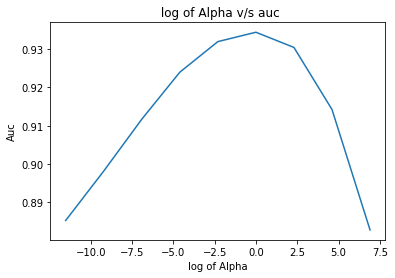

In [18]:
x = []
y = []

import math

for i in gsv.grid_scores_:
    #print(i)
    x.append(i[0]['alpha'])
    y.append(i[1])
x_1 = []
for j in x:
    x_1.append(math.log(j))
#print(x_1)
    
plt.xlabel('log of Alpha')
plt.ylabel('Auc')
plt.plot(x_1,y)
plt.title(' log of Alpha v/s auc')
plt.show()

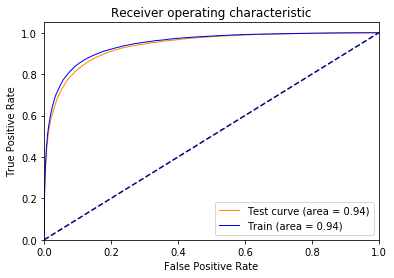

Accuracy on test set: 0.86%
Precision on test set: 0.86%
Recall on test set: 0.87%
F1 score on test set: 0.86%


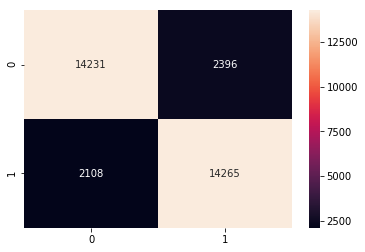

In [19]:
#now with alpha = 1
nb = MultinomialNB(alpha=1)
nb.fit(X_tra, Y_train)
y_pred = nb.predict_proba(X_tes)
y_pr = nb.predict(X_tes)
y_pred_tr = nb.predict_proba(X_tra)
y_pr_tr = nb.predict(X_tra)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#import scikitplot as skplt
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')
#skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
#plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))

In [20]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,nb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-12.3097	aaa            				-4.5587	like           
	-12.3097	aaaaa          				-4.5696	tast           
	-12.3097	aaaaaaarrrrrggghhh				-4.6113	love           
	-12.3097	aaaaaahhhhh    				-4.6152	great          
	-12.3097	aaaaaahhhhhyaaaaaa				-4.6443	good           
	-12.3097	aaaahhhhhh     				-4.7567	flavor         
	-12.3097	aachen         				-4.8568	product        
	-12.3097	aamzon         				-4.8603	use            
	-12.3097	aap            				-4.9433	one            
	-12.3097	aappubl        				-5.0280	tri            


# Observations

* From above figure after training step, it can be seen that the AUC score increases at first and then increases with the increase in the value of the hyperparameter(Through the range of specified alpha).
* When the model is tested on the test data, the values of various performace measures are printed above, the accuracy being 86%
* In confusion matrix, It is clear that out of 33k unseen data-points classifier predicts 14231 +ve and 14265 -ve class label correctly.
* For the top 10 features, the feature importance is given in the table above.
* In summary, it can be said that this model works pretty well on the unseen data.

# [3.2] TF-IDF

In [21]:
tfidf_vect = TfidfVectorizer()
X_trai = tfidf_vect.fit_transform(X_train)
X_tra = preprocessing.normalize(X_trai)
X_te = tfidf_vect.transform(X_test)
X_tes = preprocessing.normalize(X_te)
print(X_tra.shape)
print(X_tes.shape)

(77000, 34115)
(33000, 34115)


In [22]:
# Time based splitting
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
a = {'alpha':[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]} #different values of alpha

In [23]:
from sklearn.metrics import roc_curve, auc, make_scorer
def custom_auc(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label='positive')    
    return auc(fpr, tpr)

auc_ = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

nb = MultinomialNB()
gsv = GridSearchCV(nb,a,cv=tscv, verbose=1, scoring=auc_)
gsv.fit(X_tra,Y_train)
print('Best alpha: ', gsv.best_params_)
print('Best score with the above alpha: ', gsv.best_score_*100)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   26.0s finished


Best alpha:  {'alpha': 10}
Best score with the above alpha:  93.1433106811


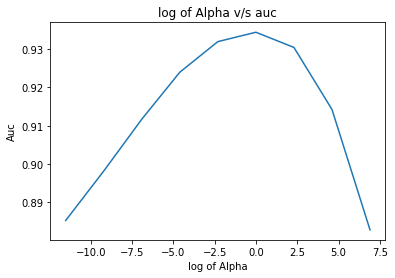

In [25]:
x1 = []
y1 = []

import math

for i in gsv.grid_scores_:
    #print(i)
    x1.append(i[0]['alpha'])
    y1.append(i[1])
x_2 = []
for j in x:
    x_2.append(math.log(j))
#print(x_1)
    
plt.xlabel('log of Alpha')
plt.ylabel('Auc')
plt.plot(x_2,y)
plt.title('log of Alpha v/s auc')
plt.show()

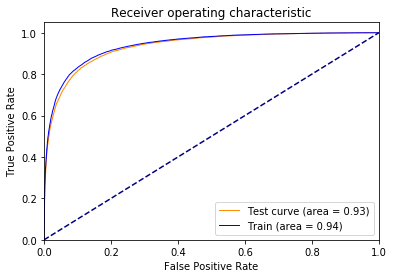

Accuracy on test set: 0.86%
Precision on test set: 0.85%
Recall on test set: 0.87%
F1 score on test set: 0.86%


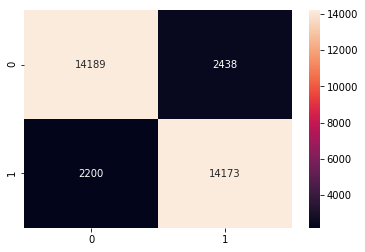

In [26]:
#now with alpha = 10
nb = MultinomialNB(alpha=10)
nb.fit(X_tra, Y_train)
y_pred = nb.predict_proba(X_tes)
y_pr = nb.predict(X_tes)
y_pred_tr = nb.predict_proba(X_tra)
y_pr_tr = nb.predict(X_tra)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_pred[:,1], pos_label='positive')
fpr_tr, tpr_tr, thresholds_tr = roc_curve(Y_train, y_pred_tr[:,1], pos_label='positive')

roc_auc_te = auc(fpr, tpr)
roc_auc_tr = auc(fpr_tr, tpr_tr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Test curve (area = %0.2f)' % roc_auc_te)
plt.plot(fpr_tr, tpr_tr, color='blue', lw=1, label='Train (area = %0.2f)' % roc_auc_tr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#import scikitplot as skplt
ax = sns.heatmap(confusion_matrix(Y_test, y_pr), annot=True, fmt='d')
#skplt.metrics.plot_confusion_matrix(Y_test, y_pred)
#plt.show()

print('Accuracy on test set: %0.2f%%'%(accuracy_score(Y_test, y_pr)))
print('Precision on test set: %0.2f%%'%(precision_score(Y_test, y_pr, pos_label='positive')))
print('Recall on test set: %0.2f%%'%(recall_score(Y_test, y_pr, pos_label='positive')))
print('F1 score on test set: %0.2f%%'%(f1_score(Y_test, y_pr, pos_label='positive')))

In [27]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf_vect,nb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-10.8623	aaa            				-6.0118	great          
	-10.8623	aaaaa          				-6.0561	love           
	-10.8623	aaaaaaarrrrrggghhh				-6.1537	good           
	-10.8623	aaaaaahhhhh    				-6.2158	tast           
	-10.8623	aaaaaahhhhhyaaaaaa				-6.2181	like           
	-10.8623	aaaahhhhhh     				-6.2377	flavor         
	-10.8623	aachen         				-6.2456	tea            
	-10.8623	aamzon         				-6.2597	coffe          
	-10.8623	aap            				-6.3372	use            
	-10.8623	aappubl        				-6.3949	product        


# Observations

* The value of hyperparameter with highest AUC score is 10, which is very high from the bag of words representaion where it was found to be 1.
* Here also, the AUC score increase initially and then decreased drastically with the increase in the value of alpha.
* The scores for performance evaluation are given above with the confusion matrix.
* From the confusion matrix we can see that 14189 +ve points and 14173 -ve points were classified correctly by the model thus created.
* Overall, the model is not so bad.

# Summary

In [28]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter", "AUC Score"]

x.add_row(["BoW", 1, 0.94])
x.add_row(["Tf-idf", 10, 0.93])

print(x)

+------------+----------------+-----------+
| Vectorizer | Hyperparameter | AUC Score |
+------------+----------------+-----------+
|    BoW     |       1        |    0.94   |
|   Tf-idf   |       10       |    0.93   |
+------------+----------------+-----------+
